
# Домашняя контрольная работа №2

**Студент:** Мальцев С. А.

**Группа:** ЕТ-313

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import os
import cv2
from pathlib import Path
import random
from tqdm import tqdm
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW, Adam
from tensorflow.keras.regularizers import l2

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

## Часть 1. Генерация синтетического набора данных

- **Классы:** 4 класса животных (dog, cat, racoon, capybara)
- **Фоны:** garbage, house, lawn, pond (имеют разные веса для каждого класса)
- **Количество изображений:**
  - Обучающая выборка: 600 изображений на класс
  - Валидационная выборка: 100 изображений на класс
  - Тестовая выборка: 100 изображений на класс
- **Аугментации:** масштабирование, поворот, отражение, изменение яркости/контраста, добавление шума



In [46]:
BASE_PATH = "synthetic_dataset"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
VAL_PATH = os.path.join(BASE_PATH, "validation")
TEST_PATH = os.path.join(BASE_PATH, "test")

CLASSES = ['capybara', 'cat', 'dog']
NUM_CLASSES = len(CLASSES)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

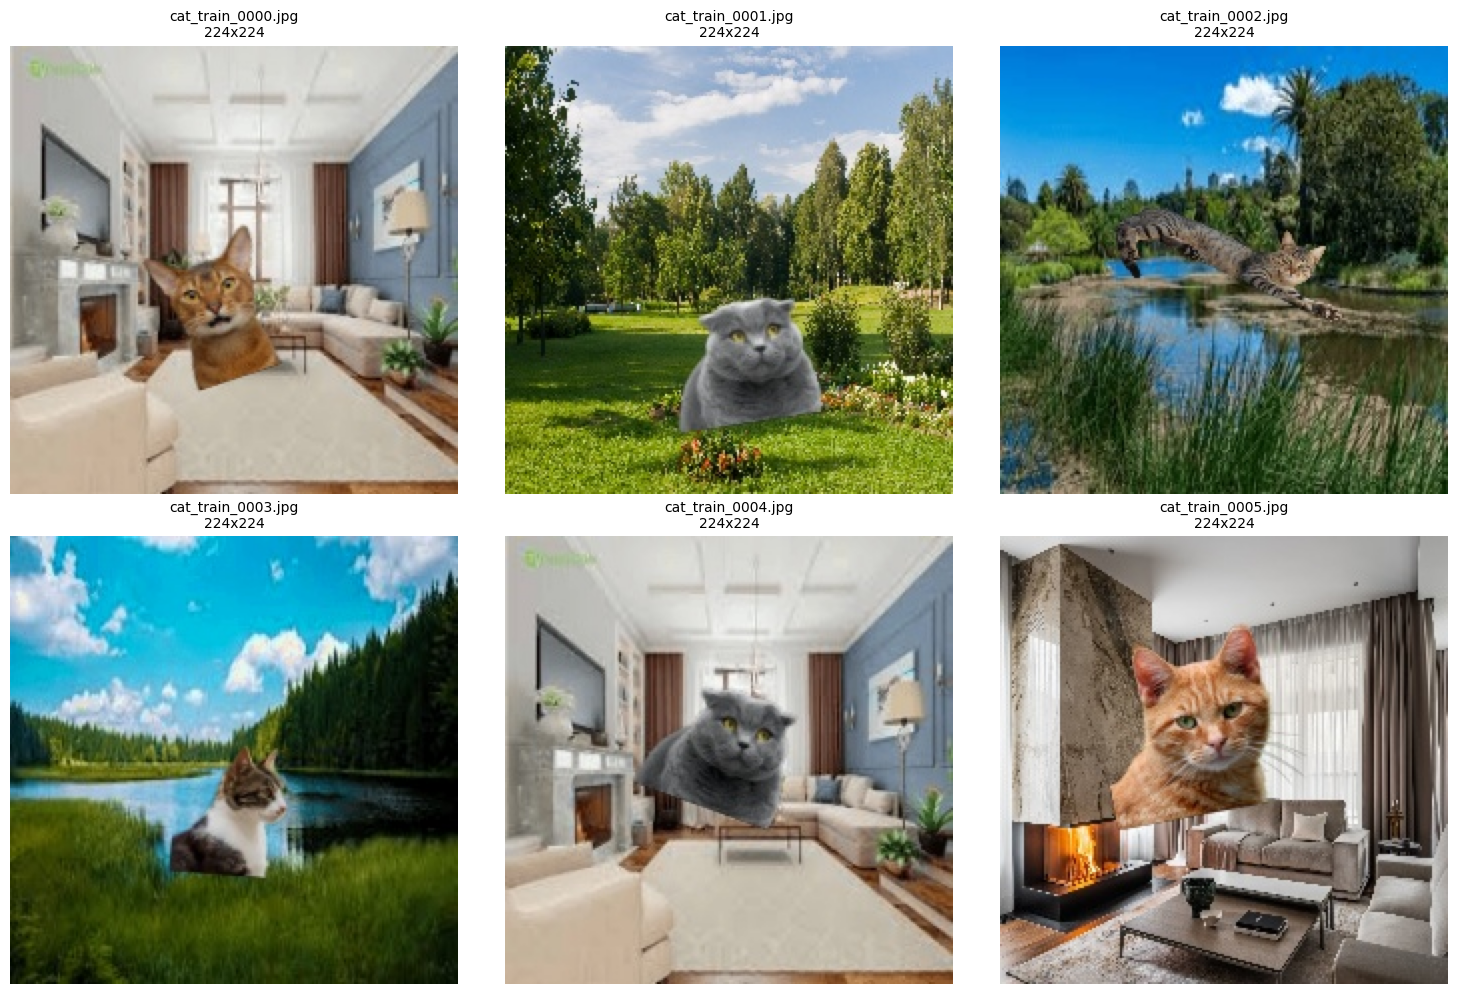

In [47]:
FOLDER_PATH = os.path.join(TRAIN_PATH, "cat")
folder = Path(FOLDER_PATH)
image_files = []
for f in os.listdir(FOLDER_PATH):
    if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        image_files.append(f)
image_files = image_files[:6]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, filename in enumerate(image_files):
    if i >= 6:
        break
    img_path = os.path.join(FOLDER_PATH, filename)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    row = i // 3
    col = i % 3
    
    axes[row, col].imshow(img_rgb)
    axes[row, col].set_title(f"{filename}\n{img.shape[1]}x{img.shape[0]}", fontsize=10)
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

# Часть 2. Создание и дообучение нейронной сети

In [48]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

print(f"\nКоличество классов: {train_generator.num_classes}")
print(f"Классы: {list(train_generator.class_indices.keys())}")
print(f"Размер батча: {BATCH_SIZE}")
print(f"Размер тренировочной выборки: {train_generator.samples}")
print(f"Размер валидационной выборки: {val_generator.samples}")
print(f"Размер тестовой выборки: {test_generator.samples}")

Found 1800 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.

Количество классов: 3
Классы: ['capybara', 'cat', 'dog']
Размер батча: 32
Размер тренировочной выборки: 1800
Размер валидационной выборки: 300
Размер тестовой выборки: 300


In [49]:
def create_transfer_learning_model(input_shape=(224, 224, 3), 
                                  num_classes=4,
                                  fine_tune_layers=10):
    base_model = applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )
    
    base_model.trainable = False
    
    model = keras.Sequential([
        base_model,
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu', 
                    kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    if fine_tune_layers > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-fine_tune_layers]:
            layer.trainable = False
        print(f"Дообучение последних {fine_tune_layers} слоев базовой модели")
    
    return model, base_model


In [50]:
model, base_model = create_transfer_learning_model(
    input_shape=(224, 224, 3),
    num_classes=NUM_CLASSES,
    fine_tune_layers=20
)

print("Архитектура модели:")
model.summary()

trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
total_params = trainable_params + non_trainable_params

print(f"\nКоличество параметров:")
print(f"  Обучаемые: {trainable_params:,}")
print(f"  Необучаемые: {non_trainable_params:,}")
print(f"  Всего: {total_params:,}")

Дообучение последних 20 слоев базовой модели
Архитектура модели:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,051 (91.99 MB)

 Trainable params: 8,408,067 (32.07 MB)

 Non-trainable params: 15,705,984 (59.91 MB)


Количество параметров:
  Обучаемые: 8,408,067
  Необучаемые: 15,705,984
  Всего: 24,114,051


Использую предобученный ResNet50 на датасете ImageNet, ResNet50 выбрал потому что самый простой выбор (также нам на семинарах ML говорили его брать, если еще не знаете что делать). 10 слоев для дообучения не так много и не так мало, плюсом данных не так много и они синтетические. Новые слои более менее выбирал случайно, dropout-ы для регуляризации, не сильно большие сверточные слои.

# Часть 3. Обоснование выбора гиперпараметров

In [51]:
optimizer = AdamW(
    learning_rate=0.00002,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)

loss = 'categorical_crossentropy'
metrics = [
    keras.metrics.CategoricalAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    # tfa.metrics.F1Score(name='f1_score'), Что-то с этим сделать надо
    keras.metrics.AUC(name='auc', multi_label=True)
]

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

print("Модель успешно скомпилирована")
print(f"Оптимизатор: {optimizer}")
print(f"Learning rate: {optimizer.learning_rate.numpy()}")
print(f"Функция потерь: {loss}")
print(f"Метрики: {[m.name for m in metrics]}")

Модель успешно скомпилирована
Оптимизатор: <keras.src.optimizers.adamw.AdamW object at 0x0000022EA9CBC410>
Learning rate: 1.9999999494757503e-05
Функция потерь: categorical_crossentropy
Метрики: ['accuracy', 'precision', 'recall', 'auc']


In [52]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

In [53]:
hyperparams_table = pd.DataFrame({
    'Параметр': [
        'Оптимизатор',
        'Learning rate',
        'Функция потерь',
        'Batch size',
        'Эпохи',
        'Метрики'
    ],
    'Значение': [
        'AdamW',
        '0.00002',
        'Categorical Cross-Entropy',
        '32',
        '25 (ранняя остановка)',
        'Accuracy, Precision, Recall, F1, AUC'
    ],
    'Обоснование': [
        'Адаптивный learning rate, быстрая сходимость, стабильность',
        'Уменьшенный LR для fine-tuning, предотвращение разрушения предобученных весов',
        'Многоклассовая классификация с one-hot кодированием меток',
        'Баланс между скоростью обучения и стабильностью градиентов',
        'Предотвращение переобучения через раннюю остановку',
        'Метрики'
    ]
})

print("Таблица выбора гиперпараметров:")
display(hyperparams_table)

Таблица выбора гиперпараметров:


,Параметр,Значение,Обоснование
0,Оптимизатор,AdamW,"Адаптивный learning rate, быстрая сходимость, ..."
1,Learning rate,0.00002,"Уменьшенный LR для fine-tuning, предотвращение..."
2,Функция потерь,Categorical Cross-Entropy,Многоклассовая классификация с one-hot кодиров...
3,Batch size,32,Баланс между скоростью обучения и стабильность...
4,Эпохи,25 (ранняя остановка),Предотвращение переобучения через раннюю остан...
5,Метрики,"Accuracy, Precision, Recall, F1, AUC",Метрики


In [54]:
EPOCHS = 25

print("Начало обучения модели...")
print(f"Количество эпох: {EPOCHS}")
print(f"Размер тренировочной выборки: {train_generator.samples}")
print(f"Размер валидационной выборки: {val_generator.samples}")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

Начало обучения модели...
Количество эпох: 25
Размер тренировочной выборки: 1800
Размер валидационной выборки: 300
Epoch 1/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3994 - auc: 0.5518 - loss: 2.1311 - precision: 0.4065 - recall: 0.3526
Epoch 1: val_accuracy improved from None to 0.19667, saving model to best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.3956 - auc: 0.5551 - loss: 2.1151 - precision: 0.4031 - recall: 0.3511 - val_accuracy: 0.1967 - val_auc: 0.4245 - val_loss: 1.6191 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.0000e-05
Epoch 2/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 0.3777 - auc: 0.5690 - loss: 2.0845 - precision: 0.3921 - recall: 0.3397
Epoch 2: val_accuracy improved from 0.19667 to 0.31000, saving model to best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.3928 - auc: 0.5715 - loss: 2.0867 - precision: 0.4025 - recall: 0.3511 - val_accuracy: 0.3100 - val_auc: 0.4533 - val_lo

# Часть 4. Графики обучения и метрики 

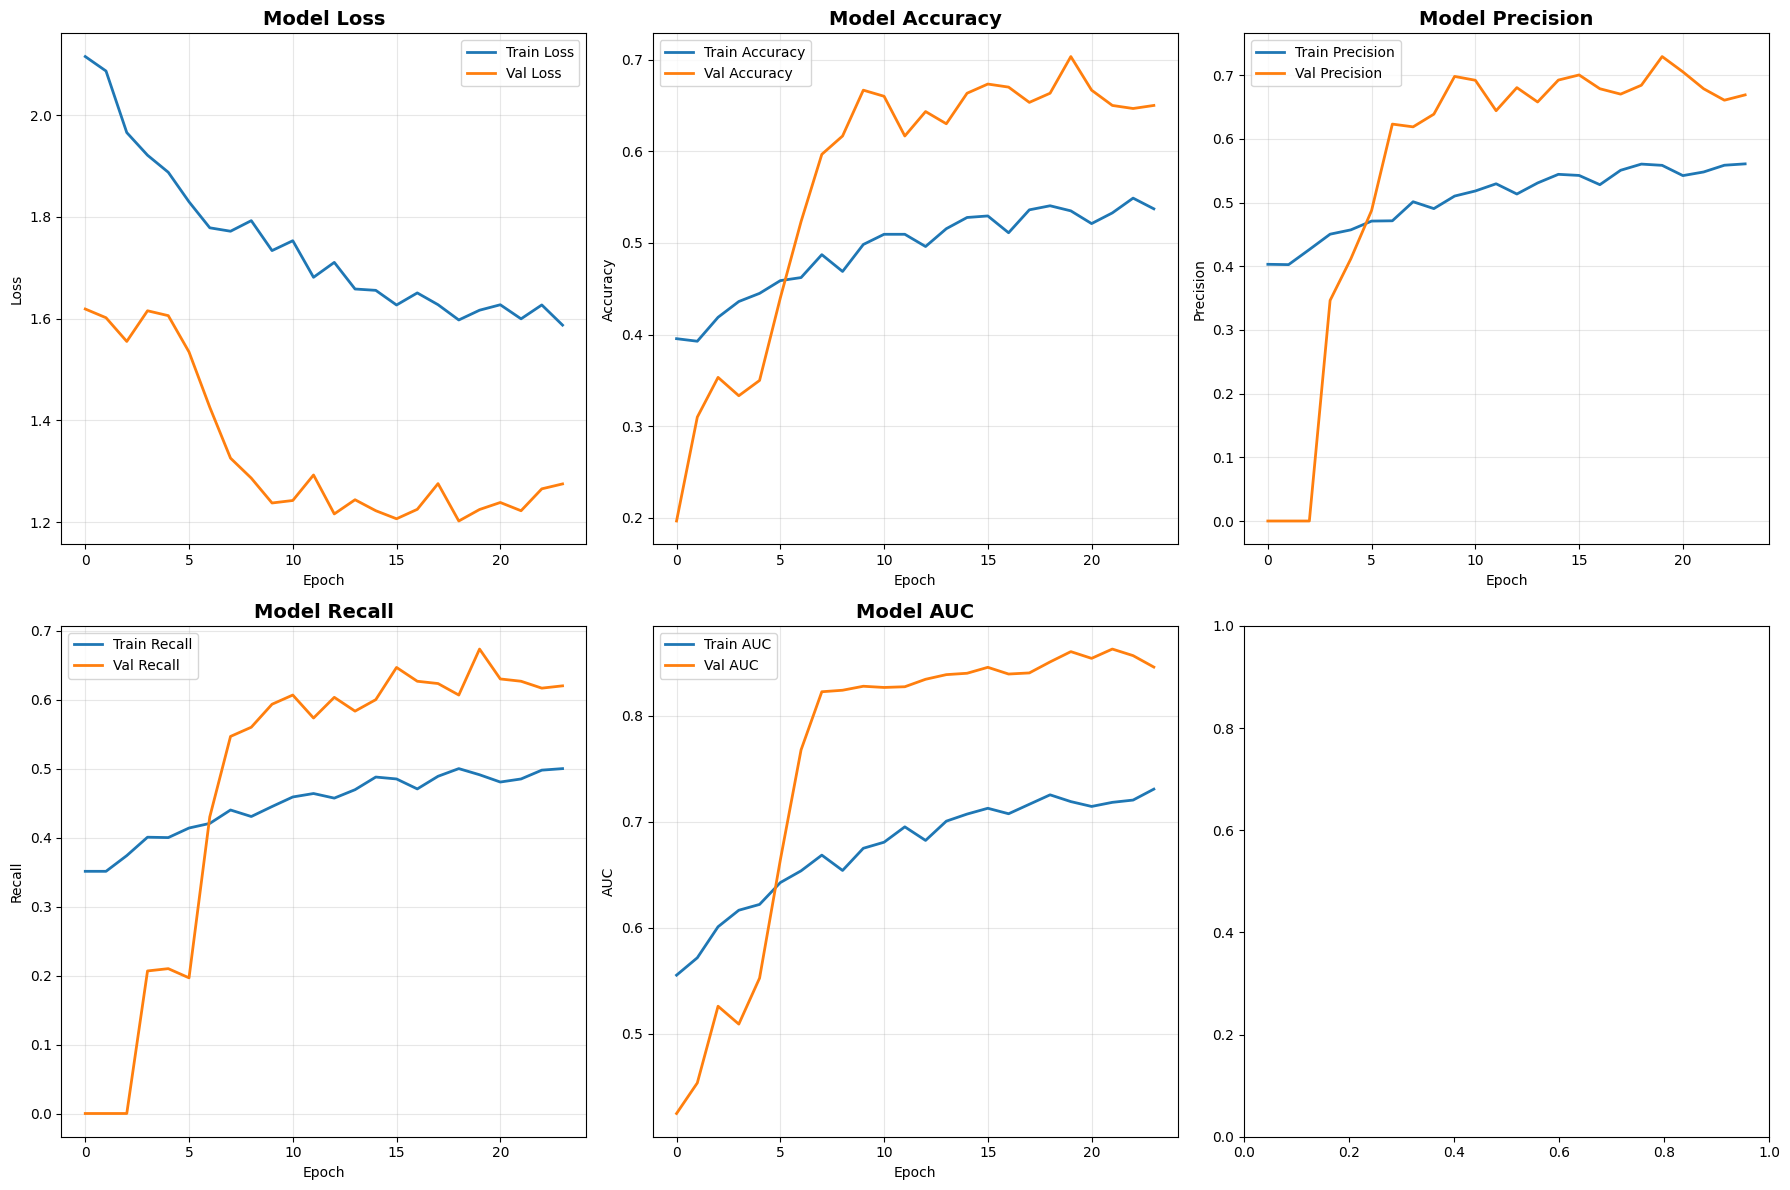

Финальный тренировочный loss: 1.5874
Финальный валидационный loss: 1.2754
Финальная тренировочная accuracy: 0.5372
Финальная валидационная accuracy: 0.6500
Разрыв в loss: 0.3120
Разрыв в accuracy: 0.1128


In [55]:

def plot_training_history(history):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    axes[0, 2].plot(history.history['precision'], label='Train Precision', linewidth=2)
    axes[0, 2].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
    axes[0, 2].set_title('Model Precision', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Precision')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    axes[1, 0].plot(history.history['recall'], label='Train Recall', linewidth=2)
    axes[1, 0].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
    axes[1, 0].set_title('Model Recall', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].plot(history.history['auc'], label='Train AUC', linewidth=2)
    axes[1, 1].plot(history.history['val_auc'], label='Val AUC', linewidth=2)
    axes[1, 1].set_title('Model AUC', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('AUC')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    if 'lr' in history.history:
        axes[1, 2].plot(history.history['lr'], label='Learning Rate', linewidth=2, color='red')
        axes[1, 2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('Learning Rate')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
        axes[1, 2].set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    
    print(f"Финальный тренировочный loss: {final_train_loss:.4f}")
    print(f"Финальный валидационный loss: {final_val_loss:.4f}")
    print(f"Финальная тренировочная accuracy: {final_train_acc:.4f}")
    print(f"Финальная валидационная accuracy: {final_val_acc:.4f}")
    
    loss_gap = abs(final_train_loss - final_val_loss)
    acc_gap = abs(final_train_acc - final_val_acc)
    
    print(f"Разрыв в loss: {loss_gap:.4f}")
    print(f"Разрыв в accuracy: {acc_gap:.4f}")

plot_training_history(history)

Очень странная тенденция, модель похоже вообще не могла узнать ни кого из датасета и просто переобучалась на сгенеренных данных (их относительно мало и они похожи не смотря на все аугментации)

Пытался это исправить сменой модели, изменением слоев, кол-во слоев участвующих в дообучении, гиперпараметры менял, ничего не помогло. Видимо создание синтетического датасета само по себе неправильно :/

In [60]:
model = keras.models.load_model('best_model.keras')
print("\nОценка модели на тестовой выборке:")
test_results = model.evaluate(test_generator, verbose=0)

metrics_names = model.metrics_names
for name, value in zip(metrics_names, test_results):
    print(f"{name}: {value:.4f}")


Оценка модели на тестовой выборке:
loss: 1.1698
compile_metrics: 0.6933


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 888ms/step


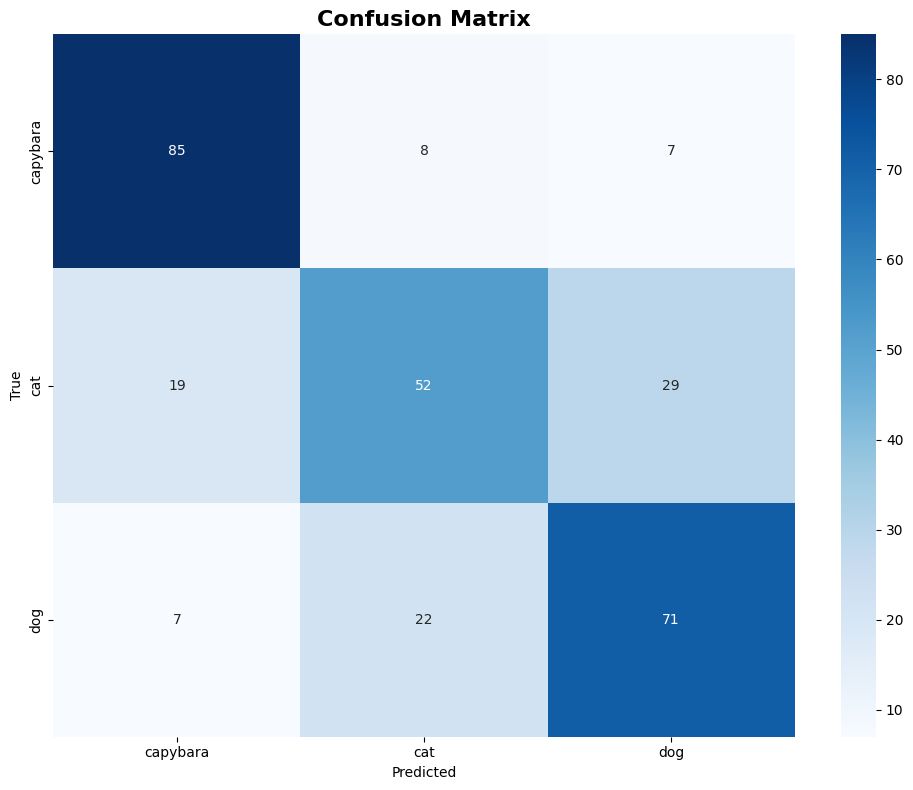

In [57]:
test_generator.reset()
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

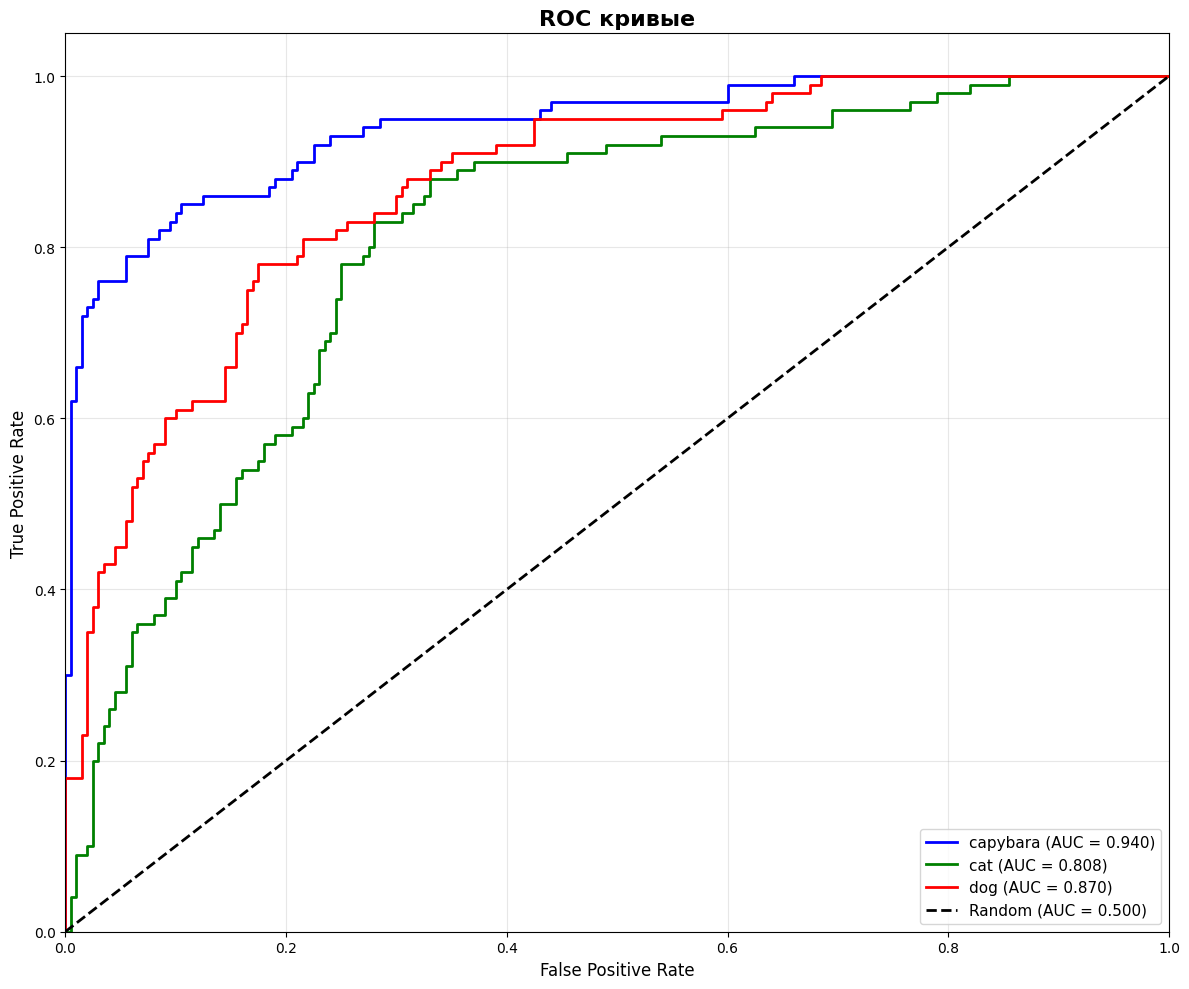

Средний AUC: 0.8729


In [58]:
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

plt.figure(figsize=(12, 10))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = ['blue', 'green', 'red', 'orange']
for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
            label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC кривые', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

mean_auc = np.mean(list(roc_auc.values()))
print(f"Средний AUC: {mean_auc:.4f}")

In [61]:
report = classification_report(y_true, y_pred_classes,
                              target_names=class_names,
                              digits=4,
                              output_dict=True)

report_df = pd.DataFrame(report).transpose()

print("\nТаблица метрик по классам:")
display(report_df[['precision', 'recall', 'f1-score']].iloc[:-3])


Таблица метрик по классам:


,precision,recall,f1-score
capybara,0.765766,0.85,0.805687
cat,0.634146,0.52,0.571429
dog,0.663551,0.71,0.685990


# Вывод

Синтетический датасет оказался совсем неестественным (летающие коты ). Хоть это и позволило создать датасет практически из ничего, но он не имеет ценности, ведь даже с аугментациями изображения выглядят очень похожими.

Модель получилась такая себе и похоже переобучилась на данных, не знаю как так получилось что стоковая модель не могла распознать никого из датасета. Похоже неправильно что-то сделал в генерации датасета.